In [13]:
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm
import string


In [2]:
PATH = '../dataset/Date-Synth/images/'

In [3]:
ANNOTATIONS_PATH = '../dataset/Date-Synth/annotations.json'

with open(ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

In [4]:
get_y_from_json('00001.jpg')

'10 10 2016'

Loading images: 100%|██████████| 20000/20000 [00:14<00:00, 1420.86it/s]


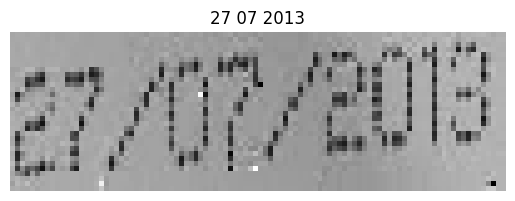

In [9]:
# Load dataset

X = []
Y = []

target_size = (32, 100)

n = 20000

for idx, file in enumerate(tqdm(os.listdir(PATH)[:n], total=n, desc="Loading images")):

    file_path = os.path.join(PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)

    label = get_y_from_json(file)

    if label != " ":
        X.append(image)
        Y.append(label)

X = np.array(X)
Y = np.array(Y)
    
plt.imshow(X[100], cmap='gray')
plt.title(Y[100])
plt.axis('off')
plt.show()

In [12]:
# Normalized

X_normalized = X / 255.0

print(f'X shape: {X_normalized.shape} | Y shape: {Y.shape}')
print(f'X_normalized[0]: {X_normalized[0]} | Y[0]: {Y[0]}')

X shape: (20000, 32, 100, 1) | Y shape: (20000,)
X_normalized[0]: [[[0.98039216]
  [0.98039216]
  [0.98039216]
  ...
  [0.98039216]
  [0.98039216]
  [0.98039216]]

 [[0.98039216]
  [0.98039216]
  [0.98039216]
  ...
  [0.98039216]
  [0.98039216]
  [0.98039216]]

 [[0.98039216]
  [0.98039216]
  [0.98039216]
  ...
  [0.98039216]
  [0.98039216]
  [0.98039216]]

 ...

 [[0.98039216]
  [0.98039216]
  [0.98039216]
  ...
  [0.98039216]
  [0.98039216]
  [0.98039216]]

 [[0.98039216]
  [0.98039216]
  [0.98039216]
  ...
  [0.98039216]
  [0.98039216]
  [0.98039216]]

 [[0.98039216]
  [0.98039216]
  [0.98039216]
  ...
  [0.98039216]
  [0.98039216]
  [0.98039216]]] | Y[0]: 21 09 2020


In [42]:
# Encode

char_list = string.ascii_letters + string.digits + ' ' # Digits because only for expiration date

index_to_char = {idx: character for idx, character in enumerate(char_list)}

def encode_label(label: str) -> list:
    
    encoded = []

    for char in label:
        try:
            encoded.append(char_list.index(char))
        except:
            print(f'Not found in char_list: {char}')

    return encoded

Y_encoded = [encode_label(label) for label in Y]

print(''.join([index_to_char[encode_idx] for encode_idx in Y_encoded[0]]))

21 09 2020


In [46]:
# Max sequence len

max_len = max(len(seq) for seq in Y_encoded)

max_len

11

In [47]:
# Pad sequence

Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded, maxlen= max_len, padding='post', value=len(char_list))

In [21]:
# Define input shape

input_shape = X[0].shape

input_shape

(32, 100, 1)

In [27]:
class MapToSequenceLayer(tf.keras.layers.Layer):

    def call(self, inputs):

        # Input = (batch_size, height, width, channels) => Feature Map

        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = tf.shape(inputs)[3]


        # Output = (batch_size, width, height * channels) => sequence per columns

        outputs = tf.reshape(inputs, (batch_size, width, height * channels) )

        return outputs

In [48]:
# Model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(512, kernel_size=(2, 2), padding='valid', activation='relu'),
    MapToSequenceLayer(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation='relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation='relu')),
    tf.keras.layers.Dense(len(char_list), activation='softmax')
])

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 32, 100, 64)       640       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 16, 50, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 16, 50, 128)       73856     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 8, 25, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 8, 25, 256)        295168    
                                                                 
 conv2d_66 (Conv2D)          (None, 8, 25, 256)       